# Flux with MNIST


## Libraries

In [1]:
using CUDA

using Flux              # the julia ml library
using Images            # image processing and machine vision for julia

using MLJ               # make_blobs, rmse, confmat, f1score, coerce
#using MLJFlux           # NeuralNetworkClassifier, CUDALibs
using MLDataUtils       # label, nlabel, labelfreq, stratifiedobs
using MLDatasets        # mnist

using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
using Distributions

using Plots; gr()
using StatsPlots
using Printf

#using CSV
using DataFrames


## Functions

In [2]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(multiclass_f1score(ŷ, y); digits=3))
end


printMetrics (generic function with 1 method)

## Dataset

,,,,

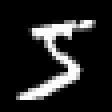
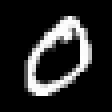
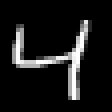
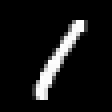
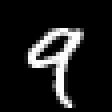

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [3]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [4]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Preprocessing

Flux primarily works with matrices and vectors

In [5]:
function preprocess(X, y)
    Xs = Float32.(X) |> Flux.flatten
    ys = Flux.onehotbatch( Float32.(y), 0:9 )
    
    return (Xs, ys)
end

h, v, N = size(trainX); d = h * v
X, y = preprocess(trainX, trainY);

In [6]:
d, N, size(X), size(y)

(784, 42001, (784, 42001), (10, 42001))

### Model

In [7]:
# data on gpu
X_d = X |> gpu
y_d = y |> gpu;


In [8]:
# model configuration
nInputs  = d
nOutputs = 10
model = Flux.Dense(nInputs, nOutputs, relu) |> gpu                  # weights on gpu
#model = Chain( Flux.Dense(nInputs, nOutputs, identity), softmax)

losses(X, y)    = Flux.crossentropy( model(X), y )
modelParameters = Flux.params(model)
#dataLoader = (X_d, y_d)
dataLoader      = Flux.DataLoader((X_d, y_d), batchsize=1024)
callBack        = Flux.throttle(() -> println("training"), 10);


### Train

In [9]:
# Flux.train!(loss, params, data, opt; cb)
@time Flux.train!(losses, modelParameters, dataLoader, Descent())   # single epoch
@time Flux.train!(losses, modelParameters, dataLoader, Descent())   # single epoch

# cpu time (batchsize=1): 2-3s

 59.119126 seconds (126.87 M allocations: 7.310 GiB, 2.96% gc time)
  0.049812 seconds (61.84 k allocations: 3.804 MiB, 31.14% compilation time)


In [10]:
epochs = 10
@time for i in 1:epochs Flux.train!(losses, modelParameters, dataLoader, Descent(); cb=callBack) end

training
  0.418343 seconds (690.70 k allocations: 40.750 MiB, 46.28% compilation time)


### Predict

In [11]:
function predictOutcome(X)
    ŷ = Flux.onecold( model(X), [0:9;] )
end

ŷ = predictOutcome(X_d)
printMetrics( coerce(ŷ, OrderedFactor), coerce(trainY, OrderedFactor) )

10×10 Matrix{Int64}:
 3792     0   109    55    24   143    92    76    39    60
    0  4566   313    91    88   215   109   229   410   127
   27    36  3106   106    27    54   116    53    92    37
   34    21   194  3598     1   722    15     8   567    75
    8     2    65     6  2693    63    21    40    23   167
  162    30     9   111     5  2186    98     3   186    24
   93     8   135    40    77    91  3677     3    50     6
    3     5    95    55    28    40     1  3733    41   273
    9    38   106   101    32    49    13    29  2368    33
   18    13    39   129  1114   232     1   212   320  3362

accuracy: 0.788
f1-score: 0.782
